In [8]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
from pyfaidx import Fasta
import upsetplot
from pandarallel import pandarallel

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [4]:
p_df = pd.read_csv(proc_cfg(config['lr']['poder_protein']['protein']['summary'], od), sep='\t')
p_df = p_df.merge(mt_df[['associated_gene_biotype',
                         'structural_category', 
                         'associated_transcript',
                         'isoform',
                         'associated_gene',
                         'length']],
                  how='left',
                  left_on='tid', 
                  right_on='isoform')
p_df.rename({'associated_gene':'gid',
             'protein_sequence':'seq'}, axis=1, inplace=True)
assert len(p_df.loc[p_df.isoform.isnull()]) == 0

## First, need to filter

In [5]:
# remove NMD things
p_df = p_df.loc[p_df.protein_is_nmd == False]

# keep only things w/ full ORFs
p_df = p_df.loc[(p_df.protein_has_start_codon==True)&\
                (p_df.protein_has_stop_codon==True)]

# keep only things from annotated protein coding genes
p_df = p_df.loc[p_df.associated_gene_biotype=='Protein Coding']

# length minimum?? maybe not
print(len(p_df.index))

86306


## Merge reference AA sequences on gid + sequence

In [6]:
# get annotated AA sequencesa
fasta_file = proc_cfg(config['ref']['pc'], od)
fasta = Fasta(fasta_file)

# Extract each entry's name and sequence
ref_orfs = {
    "name": [entry.name for entry in fasta],
    "seq": [str(entry) for entry in fasta]
}

ref_orfs = pd.DataFrame(ref_orfs)
ref_orfs['gid'] =  ref_orfs.name.str.split('|', expand=True)[2]
ref_orfs = ref_orfs[['seq', 'gid']]
ref_orfs['annot_aa'] = True
ref_orfs.drop_duplicates(inplace=True)

# just going to call novel aas as those that are not in the 
# pc translations gencode file
print(len(p_df))
p_df = p_df.merge(ref_orfs, how='left', on=['gid', 'seq'])
print(len(p_df))
p_df['annot_aa'] = p_df['annot_aa'].fillna(False)
p_df.head()

86306
86306


,Chromosome,Start,Stop,Strand,Source,CDS_Source,CDS_Start,CDS_Stop,tid,pid,...,protein_has_stop_codon,protein_has_start_codon,seq,associated_gene_biotype,structural_category,associated_transcript,isoform,gid,length,annot_aa
0,chr12,4590319,4613888,+,ENSEMBL,ORFanage,4591180,4613750,ENST00000010132.6,ENSP00000010132.5,...,True,True,MPASELKASEIPFHPSIKTQDPKAEEKSPKKQKVTLTAAEALKLFK...,Protein Coding,FSM,ENST00000010132.6,ENST00000010132.6,ENSG00000010219.14,1840,True
1,chr12,7919229,7936187,-,HAVANA,ORFanage,7921415,7936034,ENST00000075120.12,ENSP00000516774.1,...,True,True,MGTQKVTPALIFAITVATIGSFQFGYNTGVINAPEKIIKEFINKTL...,Protein Coding,FSM,ENST00000075120.12,ENST00000075120.12,ENSG00000059804.18,3827,True
2,chrY,2935380,2982506,+,HAVANA,ORFanage,2953936,2979990,ENST00000155093.8,ENSP00000155093.3,...,True,True,MDEDEFELQPQEPNSFFDGIGADATHMDGDQIVVEIQEAVFVSNIV...,Protein Coding,FSM,ENST00000155093.8,ENST00000155093.8,ENSG00000067646.12,5336,True
3,chrX,48922210,48957631,-,HAVANA,ORFanage,48923176,48957570,ENST00000156084.8,ENSP00000156084.4,...,True,True,MTILPKKKPPPPDADPANEPPPPGPMPPAPRRGGGVGVGGGGTGVG...,Protein Coding,FSM,ENST00000156084.8,ENST00000156084.8,ENSG00000068308.15,2740,True
4,chr6,155395367,155455839,-,HAVANA,ORFanage,155396838,155455800,ENST00000159060.3,ENSP00000159060.2,...,True,True,MMGCWILNEGLSTILVLSWLGINFYLFIDTFYWYEEEESFHYTRVI...,Protein Coding,FSM,ENST00000159060.3,ENST00000159060.3,ENSG00000074771.4,1980,True


In [45]:
p_df[['isoform', 'annot_aa', 'structural_category']].groupby(['annot_aa', 'structural_category']).nunique()

isoform
annot_aa structural_category         
False    FSM                    23236
         NIC                    10369
         NNC                    12302
True     FSM                    34936
         NIC                     2647
         NNC                     2816

## Get our own protein sequence novelty categories
1. exact AA match
2. truncated AA match
3. novel, non-truncation AA seq

In [30]:
# 2. truncated AA match
def get_aa_seq_truncations(x, ref_orfs):
    # limit to just references from same gene
    temp = ref_orfs.loc[ref_orfs.gid == x.gid]
    for ind, entry in temp.iterrows():
        if x.seq in entry.seq:
            return True
    return False

p_df['trunc_annot_aa'] = p_df.apply(lambda x: get_aa_seq_truncations(x, ref_orfs), axis=1)


# smol_p_df = p_df.loc[p_df.annot_aa==False].head(20)
# smol_p_df['trunc_annot_aa'] = smol_p_df.apply(lambda x: get_aa_seq_truncations(x, ref_orfs), axis=1)
# pandarallel.initialize(nb_workers=8, verbose=1)
# p_df = p_df.parallel_apply(get_aa_seq_truncations, args=(ref_orfs), axis=1, progress_bar=False)

In [27]:
# seq = smol_p_df.loc[smol_p_df.trunc_annot_aa==True].head(1).seq.tolist()[0]
# gid = smol_p_df.loc[smol_p_df.trunc_annot_aa==True].head(1).gid.tolist()[0]
# temp_ref_orfs = ref_orfs.loc[ref_orfs.gid==gid, 'seq'].tolist()

In [31]:
# 3. the rest are non-matching

In [32]:
p_df.to_csv('orf_thing.tsv', sep='\t')

In [34]:
p_df['aa_seq_novelty'] = 'Novel'
p_df.loc[(p_df.annot_aa==True), 'aa_seq_novelty'] = 'Known'
p_df.loc[(p_df.annot_aa==False)&\
         (p_df.trunc_annot_aa==True), 'aa_seq_novelty'] = 'Truncation'

In [41]:
temp = p_df[['isoform', 'aa_seq_novelty', 'structural_category']].groupby(['aa_seq_novelty', 'structural_category']).nunique().rename({'isoform':'n_t'}, axis=1)
temp = temp.reset_index()
temp

,aa_seq_novelty,structural_category,n_t
0,Known,FSM,34936
1,Known,NIC,2647
2,Known,NNC,2816
3,Novel,FSM,14148
4,Novel,NIC,7325
5,Novel,NNC,9869
6,Truncation,FSM,9088
7,Truncation,NIC,3044
8,Truncation,NNC,2433


<AxesSubplot:xlabel='structural_category', ylabel='n_t'>

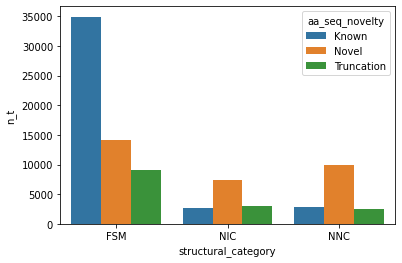

In [42]:
sns.barplot(temp, x='structural_category', hue='aa_seq_novelty', y='n_t')

In [43]:
# what about by % from each category
temp2 = p_df[['isoform', 'structural_category']].groupby('structural_category').nunique().rename({'isoform':'n_total_t'}, axis=1).reset_index()
temp = temp.merge(temp2, how='left', on='structural_category')
temp['perc'] = (temp['n_t']/temp['n_total_t'])*100

<AxesSubplot:xlabel='structural_category', ylabel='perc'>

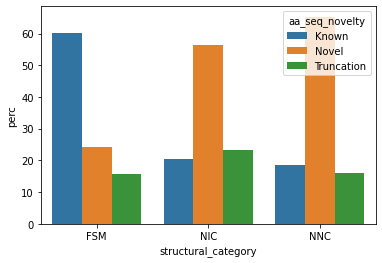

In [44]:
sns.barplot(temp, x='structural_category', hue='aa_seq_novelty', y='perc')

## Number of unique gene+aa combos detected by population

In [59]:
p_df['aa_id'] = p_df.gid+'_'+p_df.seq

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])
samples = [s for s in meta['sample'].tolist() if s in mt_df.columns]

temp = mt_df[['isoform']+samples]
temp.rename({'isoform': 'tid'}, axis=1, inplace=True)
temp.set_index('tid', inplace=True)
temp = temp.melt(ignore_index=False, var_name='sample', value_name='detected')
temp.reset_index(inplace=True)
temp = temp.merge(meta[['sample', 'map_reads_assemblymap']], 
                  how='left',
                  on='sample')

# remove undetected things
temp = temp.loc[temp.detected!=0]

# merge in the gid_seq key and aa novelty status from p_df
temp = temp.merge(p_df[['annot_aa', 'tid', 'aa_id', 'aa_seq_novelty']],
                  how='inner', #limit to only the things we care about which are already in p_df
                  on='tid')

temp.drop(['detected', 'tid'], axis=1, inplace=True)
temp = temp.groupby(['annot_aa', 'map_reads_assemblymap', 'sample', 'aa_seq_novelty']).nunique().rename({'aa_id':'n_aa'}, axis=1).reset_index()
temp['eur_noneur'] = 'Non-European'
temp.loc[(temp['sample'].str.startswith('AJI'))|\
         (temp['sample'].str.startswith('CEU')), 'eur_noneur'] = 'European'
temp['n_aa_per_million'] = (temp.n_aa/temp.map_reads_assemblymap)*1e6


<AxesSubplot:xlabel='annot_aa', ylabel='n_aa'>

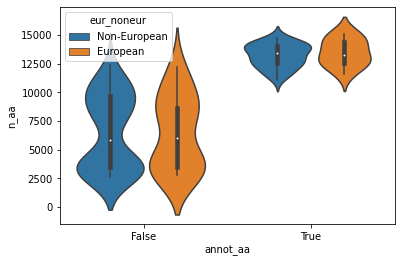

In [60]:
sns.violinplot(temp, y='n_aa', x='annot_aa', hue='eur_noneur')

<AxesSubplot:xlabel='annot_aa', ylabel='n_aa'>

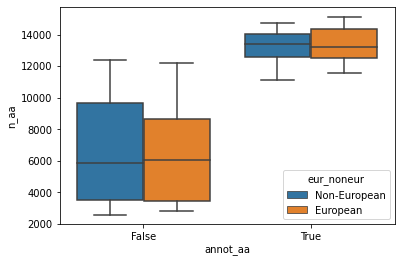

In [61]:
sns.boxplot(temp, y='n_aa', x='annot_aa', hue='eur_noneur')

In [62]:
x = temp.loc[temp.eur_noneur=='European', 'n_aa_per_million'].tolist()
y = temp.loc[temp.eur_noneur=='Non-European', 'n_aa_per_million'].tolist()
stat, pval = st.ranksums(x, y, alternative='two-sided')
print(f'Two-sided Wilcoxon rank-sum test stat: {stat}')
print(f'pval: {pval}')

Two-sided Wilcoxon rank-sum test stat: -0.04858127067234718
pval: 0.9612529961768728


<AxesSubplot:xlabel='aa_seq_novelty', ylabel='n_aa'>

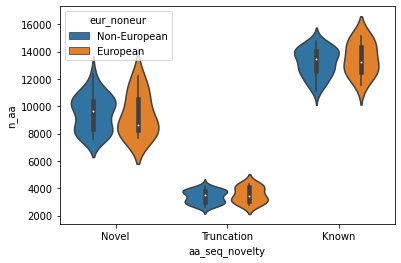

In [63]:
sns.violinplot(temp, y='n_aa', x='aa_seq_novelty', hue='eur_noneur')

In [65]:
for n in temp.aa_seq_novelty.unique().tolist():
    temp2 = temp.loc[temp.aa_seq_novelty==n].copy(deep=True)
    x = temp2.loc[temp2.eur_noneur=='European', 'n_aa_per_million'].tolist()
    y = temp2.loc[temp2.eur_noneur=='Non-European', 'n_aa_per_million'].tolist()
    stat, pval = st.ranksums(x, y, alternative='two-sided')
    print(n)
    print(f'Two-sided Wilcoxon rank-sum test stat: {stat}')
    print(f'pval: {pval}')
    print()

Novel
Two-sided Wilcoxon rank-sum test stat: -0.6680426571226848
pval: 0.5041063636520798

Truncation
Two-sided Wilcoxon rank-sum test stat: 0.3340213285613424
pval: 0.7383634642235701

Known
Two-sided Wilcoxon rank-sum test stat: 0.0
pval: 1.0



In [66]:
# what about combining FSMs and Knowns together?
temp['aa_seq_novelty_2'] = 'Known'
temp.loc[temp.aa_seq_novelty=='Novel', 'aa_seq_novelty_2'] = 'Novel'

for n in temp.aa_seq_novelty_2.unique().tolist():
    temp2 = temp.loc[temp.aa_seq_novelty_2==n].copy(deep=True)
    x = temp2.loc[temp2.eur_noneur=='European', 'n_aa_per_million'].tolist()
    y = temp2.loc[temp2.eur_noneur=='Non-European', 'n_aa_per_million'].tolist()
    stat, pval = st.ranksums(x, y, alternative='two-sided')
    print(n)
    print(f'Two-sided Wilcoxon rank-sum test stat: {stat}')
    print(f'pval: {pval}')
    print()

Novel
Two-sided Wilcoxon rank-sum test stat: -0.6680426571226848
pval: 0.5041063636520798

Known
Two-sided Wilcoxon rank-sum test stat: 0.11877113736973437
pval: 0.9054566758336993



<AxesSubplot:xlabel='aa_seq_novelty_2', ylabel='n_aa'>

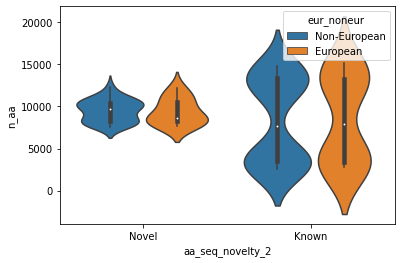

In [67]:
sns.violinplot(temp, y='n_aa', x='aa_seq_novelty_2', hue='eur_noneur')